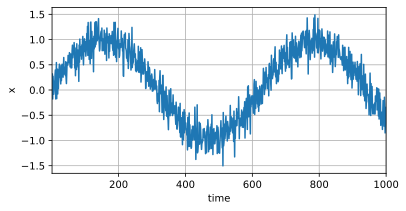

In [96]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [97]:
print(x[1])

tensor(0.3190)


In [98]:
tau = 30
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels = x[tau:]
print(labels.shape)
labels = labels.reshape((-1,1))
print(labels.shape)

batch_size , n_train = 16, 600
train_tier = d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

torch.Size([970])
torch.Size([970, 1])


In [99]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
net = nn.Sequential(nn.Linear(tau,4*tau),nn.ReLU(),
                    nn.Linear(4*tau,1))
net.apply(init_weights)
loss = nn.MSELoss(reduction='none')
def train(net, train_iter, loss ,epochs, lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    print('未训练时的loss:',d2l.evaluate_loss(net,train_iter,loss))
    for _ in range(epochs):
        for X,y in train_iter:
         trainer.zero_grad()
         l = loss(net(X),y)
         l.sum().backward()
         trainer.step()
        print(f'epoch{_ + 1},'f'loss:{d2l.evaluate_loss(net,train_iter,loss):f}')



In [100]:
train(net, train_tier,loss,5,0.01)

未训练时的loss: 0.47048441171646116
epoch1,loss:0.076101
epoch2,loss:0.046013
epoch3,loss:0.045919
epoch4,loss:0.051584
epoch5,loss:0.053999


torch.Size([970, 1])


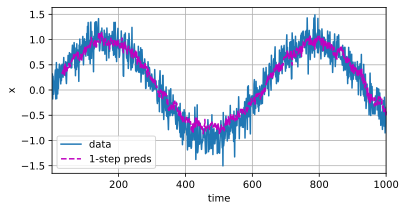

In [101]:
onestep_preds = net(features)
print(onestep_preds.shape)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

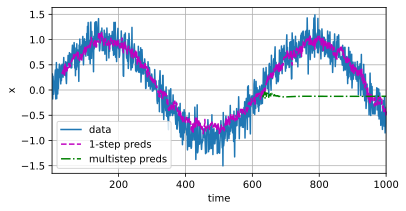

In [102]:

multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))


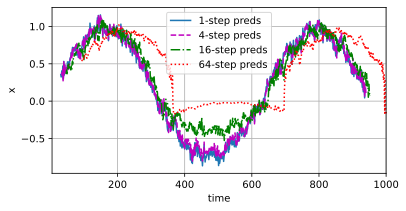

In [103]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))